<a href="https://colab.research.google.com/github/sreyaraya/HelloGit/blob/main/datatypes_demo_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install git+https://github.com/waymo-research/waymax.git@main#egg=waymo-waymax

  Cloning https://github.com/waymo-research/waymax.git (to revision main) to /tmp/pip-install-3knac46t/waymo-waymax_07b9ce7a29eb41d18f06af981cf8849b
  Running command git clone --filter=blob:none --quiet https://github.com/waymo-research/waymax.git /tmp/pip-install-3knac46t/waymo-waymax_07b9ce7a29eb41d18f06af981cf8849b
  Resolved https://github.com/waymo-research/waymax.git to commit 720f9214a9bf79b3da7926497f0cd0468ca3e630
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for waymo-waymax: filename=waymo_waymax-0.1.0-py3-none-any.whl size=210891 sha256=a5f53795a681f5a49d005c1dd1556b21c9d1e06802a3c746305f912a185c3861
  Stored in directory: /tmp/pip-ephem-wheel-cache-k9cxlteo/wheels/f8/13/c8/b03bdc1011ef34823a4b049a4b65aca4fe163a273327db83b6
Successfully built waymo-waymax


In [3]:
%%capture
import dataclasses
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes

In [4]:
# Load example data.
config = dataclasses.replace(_config.WOD_1_1_0_VALIDATION, max_num_objects=32)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)

In [5]:
log_trajectory = scenario.log_trajectory

# Number of objects stored in this trajectory.
print('Number of objects:', log_trajectory.num_objects)
print('Number of timesteps:', log_trajectory.num_timesteps)
print('Trajectory shape (num_objects, num_timesteps):', log_trajectory.shape)
print('XYZ positions (num_objects, num_timesteps, 3):', log_trajectory.xyz.shape)
print('XY velocities (num_objects, num_timesteps, 2):', log_trajectory.vel_xy.shape)
print('Yaw (num_objects, num_timesteps):', log_trajectory.yaw.shape)

Number of objects: 32
Number of timesteps: 91
Trajectory shape (num_objects, num_timesteps): (32, 91)
XYZ positions (num_objects, num_timesteps, 3): (32, 91, 3)
XY velocities (num_objects, num_timesteps, 2): (32, 91, 2)
Yaw (num_objects, num_timesteps): (32, 91)


In [6]:
# Slice by time. Select the trajectory at timestep 23.
traj_t23 = datatypes.dynamic_slice(log_trajectory, start_index=23, slice_size=1, axis=-1)
print('XYZ positions (num_objects, 1, 3):', traj_t23.xyz.shape)

# Slice by object. Select the trajectory for object 15.
traj_obj15 = datatypes.dynamic_slice(log_trajectory, start_index=15, slice_size=1, axis=-2)
print('XYZ positions (1, num_timesteps, 3):', traj_obj15.xyz.shape)

XYZ positions (num_objects, 1, 3): (32, 1, 3)
XYZ positions (1, num_timesteps, 3): (1, 91, 3)


In [7]:
def max_along_time(x: jax.Array) -> jax.Array:
  return jnp.max(x, axis=-1, keepdims=True)

max_trajectory = jax.tree_util.tree_map(max_along_time, log_trajectory)
print('XYZ positions (num_objects, 1, 3):', max_trajectory.xyz.shape)

XYZ positions (num_objects, 1, 3): (32, 1, 3)


In [8]:
zeroed_traj = dataclasses.replace(
    log_trajectory,
    yaw=log_trajectory.yaw.at[1].set(0.0)
)

# Should be the original values.
print('Yaws for object 0, timesteps 0 to 5:', zeroed_traj.yaw[0, 0:5])

# Should be now set to 0.
print('Yaws for object 1, timesteps 0 to 5:', zeroed_traj.yaw[1, 0:5])

Yaws for object 0, timesteps 0 to 5: [-0.42366624 -0.44346142 -0.4265263  -0.4287064  -0.43463445]
Yaws for object 1, timesteps 0 to 5: [0. 0. 0. 0. 0.]


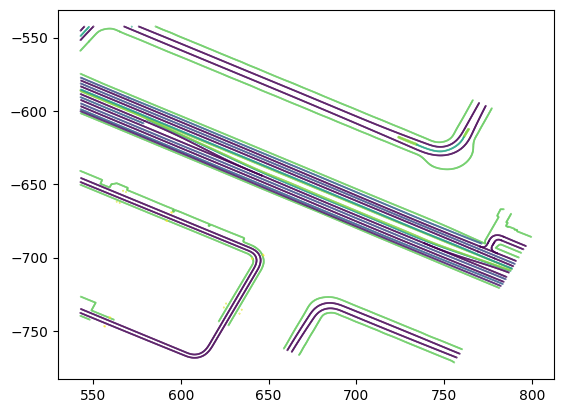

In [9]:
# Plot the roadgraph, with colors corresponding to the road type.
rg_points = scenario.roadgraph_points

where_valid = rg_points.valid
plt.scatter(
    x = rg_points.x[where_valid],
    y = rg_points.y[where_valid],
    s=0.1,
    c = rg_points.types[where_valid]
)
plt.show()

In [11]:
traffic_lights = scenario.log_traffic_light

print('Traffic Light States (num_lights, num_timesteps):', traffic_lights.shape)

Traffic Light States (num_lights, num_timesteps): (16, 91)


All object IDS: [ 70  73  92 124  71  79  68  76  69  72  75  80  77  74  90  83  82  81
  78  91  85  87  93 119  97  98  99 101 120 102  -1  -1]


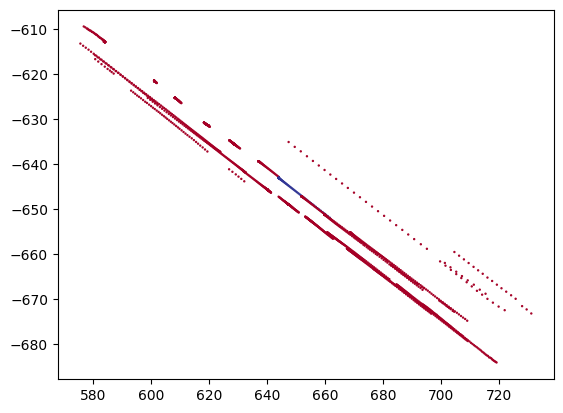

In [12]:
metadata = scenario.object_metadata
print('All object IDS:', metadata.ids)

# Color-code object trajectory by whether it is the SDC or not.
# The SDC trajectory in the center is shown in blue, and all other trajectories
# are shown in red.
flat_trajectory = jax.tree_util.tree_map(lambda x: jnp.reshape(x, [-1]), log_trajectory)
colors = jnp.zeros(log_trajectory.shape, dtype=jnp.int32).at[metadata.is_sdc].set(1)
colors = jnp.reshape(colors, [-1])

where_valid = flat_trajectory.valid
plt.scatter(
  x=flat_trajectory.x[where_valid],
  y=flat_trajectory.y[where_valid],
  s=0.5,
  c=colors[where_valid],
  cmap='RdYlBu'
)
plt.show()